In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np

plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'grey'
plt.rcParams['grid.color'] = 'lightgrey'
plt.rcParams['font.size'] = 18

In [2]:
df_basic_release = pd.read_csv('../independent_metrics/basic_release.csv', index_col='bug_id')
df_basic_beta = pd.read_csv('../independent_metrics/basic_beta.csv', index_col='bug_id')
df_basic_aurora = pd.read_csv('../independent_metrics/basic_aurora.csv', index_col='bug_id')

df_bug_inducing = pd.read_csv('../independent_metrics/bug_inducing.csv', index_col='bug_id')

df_release = pd.merge(df_basic_release, df_bug_inducing, left_index=True, right_index=True)
df_beta = pd.merge(df_basic_beta, df_bug_inducing, left_index=True, right_index=True)
df_aurora = pd.merge(df_basic_aurora, df_bug_inducing, left_index=True, right_index=True)

In [3]:
df_release = df_release[df_release.component != 'Pocket']
df_beta = df_beta[df_beta.component != 'Pocket']
df_aurora = df_aurora[df_aurora.component != 'Pocket']

In [4]:
all_names = pd.concat([pd.DataFrame(df_release.bug_assignee.ravel()), pd.DataFrame(df_beta.bug_assignee.ravel()), pd.DataFrame(df_aurora.bug_assignee.ravel())])
names = pd.unique(all_names[0])
names = pd.Series(np.arange(len(names)), names)

df_release.bug_assignee = df_release.bug_assignee.map(names.get)
df_beta.bug_assignee = df_beta.bug_assignee.map(names.get)
df_aurora.bug_assignee = df_aurora.bug_assignee.map(names.get)

In [5]:
df_release.shape

(285, 33)

In [6]:
df_beta.shape

(2614, 33)

In [7]:
df_aurora.shape

(4368, 33)

In [8]:
df_release.component = df_release.component.apply(lambda x: x.split(':')[0])
df_beta.component = df_beta.component.apply(lambda x: x.split(':')[0])
df_aurora.component = df_aurora.component.apply(lambda x: x.split(':')[0])

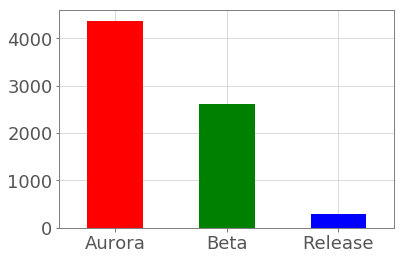

In [9]:
fig = plt.figure()
pd.Series({'Release': len(df_release), 'Beta': len(df_beta), 'Aurora': len(df_aurora)}).plot.bar(grid=True, color=['r', 'g', 'b'])
plt.xticks(rotation=0)
fig.savefig('uplifts_per_channel.pdf', format='pdf', bbox_inches='tight')

# Approved vs Rejected

In [ ]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
pd.concat([df_release['uplift_accepted'].value_counts(normalize=True).rename('Release'), df_beta['uplift_accepted'].value_counts(normalize=True).rename('Beta'), df_aurora['uplift_accepted'].value_counts(normalize=True).rename('Aurora')], axis=1)\
.plot(kind='bar', ax=ax)
plt.xticks(rotation=0)
plt.show()
fig.savefig('accepted_channels.pdf', format='pdf', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(30,30))
ax1 = fig.add_subplot(221)
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax2 = fig.add_subplot(222)
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

res1 = df_release[df_release['uplift_accepted'] == True].component.value_counts()
res1.name = 'release'
res2 = df_beta[df_beta['uplift_accepted'] == True].component.value_counts()
res2.name = 'beta'
res3 = df_aurora[df_aurora['uplift_accepted'] == True].component.value_counts()
res3.name = 'aurora'

res = pd.concat([res1, res2, res3], axis=1)

res['release_requests'] = df_release.component.value_counts()
res['beta_requests'] = df_beta.component.value_counts()
res['aurora_requests'] = df_aurora.component.value_counts()
res['release_rate'] = res['release'] / res['release_requests']
res['beta_rate'] = res['beta'] / res['beta_requests']
res['aurora_rate'] = res['aurora'] / res['aurora_requests']

res = res[(res.release_requests > 1) & (res.beta_requests > 10) & (res.aurora_requests > 20)]

res['rate_sort_val'] = res.apply(lambda x: np.nanmean([x['release_rate'], x['beta_rate'], x['aurora_rate']]), axis=1)
res['total_sort_val'] = res.apply(lambda x: np.nanmean([10 * x['release'], 2 * x['beta'], x['aurora']]), axis=1)

res\
.sort_values(['rate_sort_val', 'release_requests', 'beta_requests', 'aurora_requests'], ascending=False)[['release_rate', 'beta_rate', 'aurora_rate']]\
.rename(index=str, columns={'release_rate': 'Release', 'beta_rate': 'Beta', 'aurora_rate': 'Aurora'})\
.iloc[range(0,10)].plot(kind='bar', ax=ax1)

res\
.sort_values(['rate_sort_val', 'release_requests', 'beta_requests', 'aurora_requests'], ascending=[True, False, False, False])[['release_rate', 'beta_rate', 'aurora_rate']]\
.rename(index=str, columns={'release_rate': 'Release', 'beta_rate': 'Beta', 'aurora_rate': 'Aurora'})\
.iloc[range(0,10)].plot(kind='bar', ax=ax2)

res\
.sort_values(['total_sort_val', 'release', 'beta', 'aurora'], ascending=False)[['release', 'beta', 'aurora']]\
.rename(index=str, columns={'release': 'Release', 'beta': 'Beta', 'aurora': 'Aurora'})\
.iloc[range(0,10)].plot(kind='bar', ax=ax3)

res\
.sort_values(['total_sort_val', 'release', 'beta', 'aurora'], ascending=[True, False, False, False])[['release', 'beta', 'aurora']]\
.rename(index=str, columns={'release': 'Release', 'beta': 'Beta', 'aurora': 'Aurora'})\
.iloc[range(0,10)].plot(kind='bar', ax=ax4)

plt.show()
fig.savefig('per_component.pdf', format='pdf', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(30,30))
ax1 = fig.add_subplot(221)
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax2 = fig.add_subplot(222)
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

res1 = df_release[df_release['uplift_accepted'] == True].bug_assignee.value_counts()
res1.name = 'release'
res2 = df_beta[df_beta['uplift_accepted'] == True].bug_assignee.value_counts()
res2.name = 'beta'
res3 = df_aurora[df_aurora['uplift_accepted'] == True].bug_assignee.value_counts()
res3.name = 'aurora'

res = pd.concat([res1, res2, res3], axis=1)

res['release_requests'] = df_release.bug_assignee.value_counts()
res['beta_requests'] = df_beta.bug_assignee.value_counts()
res['aurora_requests'] = df_aurora.bug_assignee.value_counts()
res['release_rate'] = res['release'] / res['release_requests']
res['beta_rate'] = res['beta'] / res['beta_requests']
res['aurora_rate'] = res['aurora'] / res['aurora_requests']

res = res[(res.release_requests > 1) & (res.beta_requests > 10) & (res.aurora_requests > 20)]

res['rate_sort_val'] = res.apply(lambda x: np.nanmean([x['release_rate'], x['beta_rate'], x['aurora_rate']]), axis=1)
res['total_sort_val'] = res.apply(lambda x: np.nanmean([10 * x['release'], 2 * x['beta'], x['aurora']]), axis=1)

res\
.sort_values(['rate_sort_val', 'release_requests', 'beta_requests', 'aurora_requests'], ascending=False)[['release_rate', 'beta_rate', 'aurora_rate']]\
.rename(index=str, columns={'release_rate': 'Release', 'beta_rate': 'Beta', 'aurora_rate': 'Aurora'})\
.iloc[range(0,10)].plot(kind='bar', ax=ax1)

res\
.sort_values(['rate_sort_val', 'release_requests', 'beta_requests', 'aurora_requests'], ascending=[True, False, False, False])[['release_rate', 'beta_rate', 'aurora_rate']]\
.rename(index=str, columns={'release_rate': 'Release', 'beta_rate': 'Beta', 'aurora_rate': 'Aurora'})\
.iloc[range(0,10)].plot(kind='bar', ax=ax2)

res\
.sort_values(['total_sort_val', 'release', 'beta', 'aurora'], ascending=False)[['release', 'beta', 'aurora']]\
.rename(index=str, columns={'release': 'Release', 'beta': 'Beta', 'aurora': 'Aurora'})\
.iloc[range(0,10)].plot(kind='bar', ax=ax3)

res\
.sort_values(['total_sort_val', 'release', 'beta', 'aurora'], ascending=[True, False, False, False])[['release', 'beta', 'aurora']]\
.rename(index=str, columns={'release': 'Release', 'beta': 'Beta', 'aurora': 'Aurora'})\
.iloc[range(0,10)].plot(kind='bar', ax=ax4)

plt.show()
fig.savefig('per_assignee.pdf', format='pdf', bbox_inches='tight')

In [ ]:
types_approved_release = df_release[df_release['uplift_accepted'] == True].types.str.split('^').apply(pd.Series, 1).stack()
types_approved_release.index = types_approved_release.index.droplevel(-1)
types_approved_release.name = 'Release'
types_approved_beta = df_beta[df_beta['uplift_accepted'] == True].types.str.split('^').apply(pd.Series, 1).stack()
types_approved_beta.index = types_approved_beta.index.droplevel(-1)
types_approved_beta.name = 'Beta'
types_approved_aurora = df_aurora[df_aurora['uplift_accepted'] == True].types.str.split('^').apply(pd.Series, 1).stack()
types_approved_aurora.index = types_approved_aurora.index.droplevel(-1)
types_approved_aurora.name = 'Aurora'

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
pd.concat([types_approved_release.value_counts(normalize=True), types_approved_beta.value_counts(normalize=True), types_approved_aurora.value_counts(normalize=True)], axis=1)\
.plot(kind='bar', ax=ax)
plt.xticks(rotation=0)
plt.show()
fig.savefig('accepted_uplifts_per_type_and_channel.pdf', format='pdf')

In [ ]:
languages_approved_release = df_release[df_release['uplift_accepted'] == True].languages.str.split('^').apply(pd.Series, 1).stack()
languages_approved_release.index = languages_approved_release.index.droplevel(-1)
languages_approved_release.name = 'Release'
languages_approved_beta = df_beta[df_beta['uplift_accepted'] == True].languages.str.split('^').apply(pd.Series, 1).stack()
languages_approved_beta.index = languages_approved_beta.index.droplevel(-1)
languages_approved_beta.name = 'Beta'
languages_approved_aurora = df_aurora[df_aurora['uplift_accepted'] == True].languages.str.split('^').apply(pd.Series, 1).stack()
languages_approved_aurora.index = languages_approved_aurora.index.droplevel(-1)
languages_approved_aurora.name = 'Aurora'

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
pd.concat([languages_approved_release.value_counts(normalize=True), languages_approved_beta.value_counts(normalize=True), languages_approved_aurora.value_counts(normalize=True)], axis=1)\
.plot(kind='bar', ax=ax)
plt.xticks(rotation=45)
plt.show()

## Release uplifts

### Approved vs rejected uplifts per component

In [ ]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res = df_release[df_release['uplift_accepted'] == True].component.value_counts() / df_release.component.value_counts()
res.dropna().sort_values(ascending=False).plot(kind='bar', ax=ax)
plt.show()

### Approved vs rejected uplifts per bug assignee

In [ ]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res = df_release[df_release['uplift_accepted'] == True].bug_assignee.value_counts().where(lambda x: x > 2) / df_release.bug_assignee.value_counts()
res.dropna().sort_values(ascending=False).plot(kind='bar', ax=ax)
plt.show()

### Approved vs rejected uplifts per bug type

In [ ]:
types = df_release.types.str.split('^').apply(pd.Series, 1).stack()
types.index = types.index.droplevel(-1)
types.name = 'Type'
types_approved = df_release[df_release['uplift_accepted'] == True].types.str.split('^').apply(pd.Series, 1).stack()
types_approved.index = types_approved.index.droplevel(-1)
types_approved.name = 'Type'

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
res = types_approved.value_counts() / types.value_counts()
res.sort_values(ascending=False).plot(kind='bar')
plt.show()

## Beta uplifts

### Approved vs rejected uplifts per component

In [ ]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res = df_beta[df_beta['uplift_accepted'] == True].component.value_counts() / df_beta.component.value_counts()
res.dropna().sort_values(ascending=False).plot(kind='bar', ax=ax)
plt.show()

### Approved vs rejected uplifts per bug assignee

In [ ]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res = df_beta[df_beta['uplift_accepted'] == True].bug_assignee.value_counts().where(lambda x: x > 10) / df_beta.bug_assignee.value_counts()
res.dropna().sort_values(ascending=False).plot(kind='bar', ax=ax)
plt.show()

### Approved vs rejected uplifts per bug type

In [ ]:
types = df_beta.types.str.split('^').apply(pd.Series, 1).stack()
types.index = types.index.droplevel(-1)
types.name = 'Type'
types_approved = df_beta[df_beta['uplift_accepted'] == True].types.str.split('^').apply(pd.Series, 1).stack()
types_approved.index = types_approved.index.droplevel(-1)
types_approved.name = 'Type'

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
res = types_approved.value_counts() / types.value_counts()
res.sort_values(ascending=False).plot(kind='bar')
plt.show()

## Aurora uplifts

### Approved vs rejected uplifts per component

In [ ]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res = df_aurora[df_aurora['uplift_accepted'] == True].component.value_counts() / df_aurora.component.value_counts()
res.dropna().sort_values(ascending=False).plot(kind='bar', ax=ax)
plt.show()

### Approved vs rejected uplifts per bug assignee

In [ ]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
res = df_aurora[df_aurora['uplift_accepted'] == True].bug_assignee.value_counts().where(lambda x: x > 20) / df_aurora.bug_assignee.value_counts()
res.dropna().sort_values(ascending=False).plot(kind='bar', ax=ax)
plt.show()

### Approved vs rejected uplifts per bug type

In [ ]:
types = df_aurora.types.str.split('^').apply(pd.Series, 1).stack()
types.index = types.index.droplevel(-1)
types.name = 'Type'
types_approved = df_aurora[df_aurora['uplift_accepted'] == True].types.str.split('^').apply(pd.Series, 1).stack()
types_approved.index = types_approved.index.droplevel(-1)
types_approved.name = 'Type'

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
res = types_approved.value_counts() / types.value_counts()
res.sort_values(ascending=False).plot(kind='bar')
plt.show()

# Bug-inducing vs non bug-inducing